## **Technical cells**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install --upgrade torch
!pip install --upgrade wandb
!pip install --upgrade catalyst
!pip install --upgrade torchtext
!pip install --upgrade nlpaug
!wandb login c54b2fcb6b8ca2808f5be303a8a3b6e464f52cca

In [0]:
import torch
import torchtext
import nlpaug
import wandb
import catalyst
print("Torchtext Version:", torchtext.__version__)
print("PyTorch Version:", torch.__version__)
print("Catalyst Version:", catalyst.__version__)
print("Wandb Version:", wandb.__version__)
print("NLP-AUG Version:", nlpaug.__version__)

Torchtext Version: 0.6.0
PyTorch Version: 1.5.0+cu101
Catalyst Version: 20.04.2
Wandb Version: 0.8.35
NLP-AUG Version: 0.0.14


In [0]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [0]:
def get_device():
	if torch.cuda.is_available():
		return torch.device('cuda:0')
	else:
		return torch.device('cpu')

device = get_device()


## **Introducing cells**

In [0]:
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
from catalyst import dl
import wandb
import sklearn.datasets
import re
import copy
import time

DEVICE = 'cuda'
COURSEWORK_PATH = 'drive/My Drive/text-augmentation/'
AUGMENTED_DATA_PATH = COURSEWORK_PATH + 'aug_data/'
CLASS_LABELS = ['contradiction', 'entailment', 'neutral']

In [0]:
import pickle

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
# create directory for checkpoints
logdir = 'wandb-log-directory'

In [0]:
wandb.init(project="text-augmentation", dir=logdir)

## **Model description**:

In [0]:
class BiLSTM(nn.Module):
    def __init__(self, config=None, padding_idx=None):
        super(BiLSTM, self).__init__()
        vocab_size = config['vocab_size']
        h_size = config['h_size']
        dropout = config['dropout']
        n_layers = config['n_layers']
        self.embedding = nn.Embedding(vocab_size, h_size, padding_idx=padding_idx, scale_grad_by_freq=True)
        self.lstm = nn.LSTM(h_size, h_size, n_layers, bidirectional=True, dropout=dropout)
        self.out = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2 * 4 * n_layers * h_size, h_size * 3),
            nn.BatchNorm1d(h_size * 3),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(h_size * 3, h_size * 3),
            nn.BatchNorm1d(h_size * 3),
            nn.PReLU(),
            nn.Dropout(dropout),
            nn.Linear(h_size * 3, 3)
        )

        self.init_weights()

    def forward(self, batch):
        prem, hyp = batch
        prem, prem_len = prem
        hyp, hyp_len = hyp

        prem, hyp = self.embedding(prem), self.embedding(hyp)

        # optimize perfomance of RNN by omitting padding token
        prem = nn.utils.rnn.pack_padded_sequence(input=prem, lengths=prem_len, enforce_sorted=False)
        hyp = nn.utils.rnn.pack_padded_sequence(input=hyp, lengths=hyp_len, enforce_sorted=False)
        _, h_prem = self.lstm(prem)
        _, h_hyp = self.lstm(hyp)

        h_prem = torch.cat(h_prem, dim=-1)
        h_prem = h_prem.permute(1,0,2)
        h_prem = h_prem.contiguous().view(h_prem.size(0),-1)

        h_hyp = torch.cat(h_hyp, dim=-1)
        h_hyp = h_hyp.permute(1,0,2)
        h_hyp = h_hyp.contiguous().view(h_hyp.size(0),-1)

        h = torch.cat([h_prem, h_hyp],dim=-1)
        h = h.contiguous().view(h.size(0), -1)
        
        return self.out(h)
 
    def init_weights(self):
        d = self.embedding.weight.size(1)
        nn.init.uniform_(self.embedding.weight, -1.0 / np.sqrt(d), 1.0 / np.sqrt(d))

## **Vocabulary building and training the model**

In [0]:
class IteratorWrapper(DataLoader):
    __initialized__ = False

    def __init__(self, iter: iter):
        self.batch_size = iter.batch_size
        self.num_workers = 1
        self.collate_fn = None
        self.pin_memory = False
        self.drop_last = False
        self.timeout = 0
        self.worker_init_fn = None
        self.sampler = iter
        self.batch_sampler = iter
        self.__initialized__ = True

    def __iter__(self):
        return map(lambda batch: {
                    'features': (batch.premise, batch.hypothesis),
                    'targets': batch.label,
                }, self.batch_sampler.__iter__())

    def __len__(self):
        return len(self.batch_sampler)

In [0]:
%%time

TEXT = data.Field(lower=True, tokenize='spacy', include_lengths=True)
LABEL = data.LabelField(sequential=False, is_target=True)

train, valid, test = datasets.SNLI.splits(TEXT, LABEL)

/usr/local/lib/python3.6/dist-packages/_pytest/mark/structures.py:426: DeprecationWarning:

The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/local/lib/python3.6/dist-packages/thinc/neural/_custom_kernels.py:36: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.6/dist-packages/thinc/neural/_custom_kernels.cu' mode='r' encoding='utf8'>

/usr/local/lib/python3.6/dist-packages/thinc/neural/_custom_kernels.py:39: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.6/dist-packages/thinc/neural/_murmur3.cu' mode='r' encoding='utf8'>

snli_1.0.zip:   1%|          | 934k/94.6M [00:00<00:10, 9.32MB/s]

downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:01<00:00, 60.6MB/s]


extracting
CPU times: user 1min 4s, sys: 2.29 s, total: 1min 6s
Wall time: 1min 9s


In [0]:
# Set up config that stays the same for every model
config = {
    "n_layers": 4,
    "h_size": 128,
    "embed_dim": 512,
    "num_epochs": 1,
    "dropout": 0.1,
    "batch_size": 1024,
    "vocab_size": 0
}

In [0]:
import copy
source_train_examples = copy.deepcopy(train.examples)

### **Here we unite all cells into one to perform model training in every dataset:**

In [0]:
storage = ['random-insert', 'random-substitute', 'random-swap', 'random-delete', 'random-full', 'tf-idf-insert', 'tf-idf-substitute', 'tf-idf-full', 'synonym-default', 'compose-default']

In [0]:
characteristics = dict()

In [0]:
OBJECTS_DIRECTORY = "drive/My Drive/text-augmentation/objects-directory/"

def save_object(obj, name):
    with open(OBJECTS_DIRECTORY + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_object(name):
    with open(OBJECTS_DIRECTORY + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
wandb_names = ['augmented-lstm-nlpaug-' + augmenter_name for augmenter_name in storage]

for i, augmenter_name in enumerate(storage):
    # (0) Set train to default again
    train.examples = copy.deepcopy(source_train_examples)

    # (1) Merge train + augmented_train datasets
    start = time.time()
    print("started loading %s" % (augmenter_name))
    df = pd.read_csv(AUGMENTED_DATA_PATH + augmenter_name + ".csv")
    for index, row in tqdm(df.iterrows()):
        new_example = torchtext.data.example.Example()
        new_example.premise = row.premise
        new_example.hypothesis = row.hypothesis
        new_example.label = row.label
        train.examples.append(new_example)
    end = time.time()
    print("It took %.2f seconds to build %s" % (end - start, augmenter_name))
    print(f"{augmenter_name} dataset size:", len(train.examples))

    TEXT.build_vocab(train, valid, min_freq=1)
    LABEL.build_vocab(train)
    config["vocab_size"] = len(TEXT.vocab)
    print("Vocabulary size:", len(TEXT.vocab))

    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_size=config["batch_size"], device=DEVICE)
    train_iter = IteratorWrapper(train_iter)
    valid_iter = IteratorWrapper(valid_iter)
    test_iter = IteratorWrapper(test_iter)

    loaders = {'train': train_iter, 'valid': valid_iter}

    print(config['vocab_size'], TEXT.vocab.stoi[TEXT.pad_token])

    # (2) Model initialization
    model = BiLSTM(config=config, padding_idx=TEXT.vocab.stoi[TEXT.pad_token])

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, factor=0.5)

    runner = dl.SupervisedRunner(DEVICE)

    # (2.5) temporary output
    print(runner.train.__code__.co_varnames)

    # (3) run with a catalyst library
    runner.train(model=model, 
                loaders=loaders,
                num_epochs=config['num_epochs'],
                logdir="wandb-logdir",
                criterion=nn.CrossEntropyLoss(),
                optimizer=optimizer, 
                scheduler=scheduler,  
                callbacks=[
                    dl.callbacks.CheckpointCallback(2),
                    dl.callbacks.AccuracyCallback(),
                    dl.callbacks.EarlyStoppingCallback(3), # stop training, if valid loss does not improve last 3 epochs
                    dl.callbacks.WandbLogger(
                        project="text-augmentation",
                        entity='msaidov',
                        name=wandb_names[i],
                        group='nlpaug',
                        config={
                            'model': 'bilstm',
                            'optimizer': str(optimizer),
                            'scheduler': 'plateau',
                            'early_stop': 3,
                            'vocab_size': config['vocab_size'],
                            'h_size': config['h_size'],
                            'n_layers': config['n_layers'],
                            'dropout': config['dropout'],
                            'batch_size': config['batch_size'],
                            'embed_dim': config['embed_dim'],
                        },
                    )
                ],
                verbose=True)

    # (4) Evaluate on the test set
    runner = dl.SupervisedRunner()
    y_pred = runner.predict_loader(model=model, loader=test_iter)

    y_pred = np.vstack([x['logits'].cpu().numpy() for x in y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([x['targets'].cpu().numpy() for x in test_iter])

    test_score = accuracy_score(y_true, y_pred)
    print("AUGMENTER TEST SCORE: %s == %.2f" % (augmenter_name, test_score))

    # send test score to wandb
    wandb.log({'acc/test': test_score})

    characteristics[augmenter_name] = (end - start, test_score, len(train.examples))
    save_object(characteristics, "characteristics")

started loading random-insert



It took 160.44 seconds to build random-insert
random-insert dataset size: 1648101
Vocabulary size: 33962
33962 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory


wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path wandb-logdir/wandb/ wasn't writable, using sy

1/1 * Epoch (train): 100% 1610/1610 [31:20<00:00,  1.17s/it, accuracy01=0.642, loss=0.784]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.04it/s, accuracy01=0.660, loss=0.765]
[2020-05-04 16:58:09,654] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5818 | loss=0.8836
1/1 * Epoch 1 (valid): accuracy01=0.7156 | loss=0.6842


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5818 | loss=0.8836
1/1 * Epoch 1 (valid): accuracy01=0.7156 | loss=0.6842


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.6842
AUGMENTER TEST SCORE: random-insert == 0.72
started loading random-substitute



It took 160.35 seconds to build random-substitute
random-substitute dataset size: 1648101
Vocabulary size: 33962
33962 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 1610/1610 [30:08<00:00,  1.12s/it, accuracy01=0.640, loss=0.810]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.06it/s, accuracy01=0.661, loss=0.763]
[2020-05-04 17:31:46,471] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5747 | loss=0.8938
1/1 * Epoch 1 (valid): accuracy01=0.7151 | loss=0.6767


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5747 | loss=0.8938
1/1 * Epoch 1 (valid): accuracy01=0.7151 | loss=0.6767


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.6767
AUGMENTER TEST SCORE: random-substitute == 0.72
started loading random-swap



It took 157.57 seconds to build random-swap
random-swap dataset size: 1648101
Vocabulary size: 33934
33934 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 1610/1610 [30:16<00:00,  1.13s/it, accuracy01=0.650, loss=0.778]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.07it/s, accuracy01=0.669, loss=0.763]
[2020-05-04 18:05:29,312] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5833 | loss=0.8822
1/1 * Epoch 1 (valid): accuracy01=0.7158 | loss=0.6749


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5833 | loss=0.8822
1/1 * Epoch 1 (valid): accuracy01=0.7158 | loss=0.6749


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.6749
AUGMENTER TEST SCORE: random-swap == 0.72
started loading random-delete



It took 161.88 seconds to build random-delete
random-delete dataset size: 1648101
Vocabulary size: 33934
33934 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 1610/1610 [29:15<00:00,  1.09s/it, accuracy01=0.631, loss=0.800]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.09it/s, accuracy01=0.682, loss=0.758]
[2020-05-04 18:38:17,414] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5780 | loss=0.8892
1/1 * Epoch 1 (valid): accuracy01=0.7150 | loss=0.6772


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5780 | loss=0.8892
1/1 * Epoch 1 (valid): accuracy01=0.7150 | loss=0.6772


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.6772
AUGMENTER TEST SCORE: random-delete == 0.72
started loading random-full



It took 157.12 seconds to build random-full
random-full dataset size: 1648101
Vocabulary size: 33934
33934 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 1610/1610 [29:23<00:00,  1.10s/it, accuracy01=0.636, loss=0.812]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  5.97it/s, accuracy01=0.660, loss=0.763]
[2020-05-04 19:11:06,279] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5787 | loss=0.8877
1/1 * Epoch 1 (valid): accuracy01=0.7145 | loss=0.6713


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.5787 | loss=0.8877
1/1 * Epoch 1 (valid): accuracy01=0.7145 | loss=0.6713


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.6713
AUGMENTER TEST SCORE: random-full == 0.71
started loading tf-idf-insert



It took 8.75 seconds to build tf-idf-insert
tf-idf-insert dataset size: 604304
Vocabulary size: 33969
33969 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 591/591 [09:08<00:00,  1.08it/s, accuracy01=0.673, loss=0.734]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.01it/s, accuracy01=0.639, loss=0.819]
[2020-05-04 19:20:55,706] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6270 | loss=0.8114
1/1 * Epoch 1 (valid): accuracy01=0.6981 | loss=0.7114


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6270 | loss=0.8114
1/1 * Epoch 1 (valid): accuracy01=0.6981 | loss=0.7114


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.7114
AUGMENTER TEST SCORE: tf-idf-insert == 0.70
started loading tf-idf-substitute



It took 8.48 seconds to build tf-idf-substitute
tf-idf-substitute dataset size: 604304
Vocabulary size: 33969
33969 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 591/591 [07:51<00:00,  1.25it/s, accuracy01=0.664, loss=0.732]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.07it/s, accuracy01=0.623, loss=0.838]
[2020-05-04 19:29:31,728] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6265 | loss=0.8113
1/1 * Epoch 1 (valid): accuracy01=0.6959 | loss=0.7175


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6265 | loss=0.8113
1/1 * Epoch 1 (valid): accuracy01=0.6959 | loss=0.7175


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.7175
AUGMENTER TEST SCORE: tf-idf-substitute == 0.70
started loading tf-idf-full



It took 8.71 seconds to build tf-idf-full
tf-idf-full dataset size: 604304
Vocabulary size: 33968
33968 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 591/591 [07:52<00:00,  1.25it/s, accuracy01=0.649, loss=0.738]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.07it/s, accuracy01=0.633, loss=0.812]
[2020-05-04 19:38:06,979] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6262 | loss=0.8119
1/1 * Epoch 1 (valid): accuracy01=0.6999 | loss=0.7069


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6262 | loss=0.8119
1/1 * Epoch 1 (valid): accuracy01=0.6999 | loss=0.7069


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.7069
AUGMENTER TEST SCORE: tf-idf-full == 0.70
started loading synonym-default



It took 8.54 seconds to build synonym-default
synonym-default dataset size: 604304
Vocabulary size: 33932
33932 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 591/591 [07:42<00:00,  1.28it/s, accuracy01=0.669, loss=0.726]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.01it/s, accuracy01=0.634, loss=0.820]
[2020-05-04 19:46:34,582] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6289 | loss=0.8087
1/1 * Epoch 1 (valid): accuracy01=0.6985 | loss=0.7060


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6289 | loss=0.8087
1/1 * Epoch 1 (valid): accuracy01=0.6985 | loss=0.7060


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.7060
AUGMENTER TEST SCORE: synonym-default == 0.70
started loading compose-default



It took 8.59 seconds to build compose-default
compose-default dataset size: 604304
Vocabulary size: 33970
33970 1
('self', 'model', 'criterion', 'optimizer', 'scheduler', 'datasets', 'loaders', 'callbacks', 'logdir', 'resume', 'num_epochs', 'valid_loader', 'main_metric', 'minimize_metric', 'verbose', 'state_kwargs', 'checkpoint_data', 'fp16', 'distributed', 'check', 'timeit', 'load_best_on_end', 'initial_seed', 'load_on_stage_end', 'checkpoint_callback_flag', 'experiment')


1/1 * Epoch (train): 100% 591/591 [08:20<00:00,  1.18it/s, accuracy01=0.670, loss=0.723]
1/1 * Epoch (valid): 100% 10/10 [00:01<00:00,  6.04it/s, accuracy01=0.634, loss=0.826]
[2020-05-04 19:55:35,855] 
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6257 | loss=0.8108
1/1 * Epoch 1 (valid): accuracy01=0.6939 | loss=0.7117


INFO:metrics_logger:
1/1 * Epoch 1 (_base): lr=0.0010 | momentum=0.9000
1/1 * Epoch 1 (train): accuracy01=0.6257 | loss=0.8108
1/1 * Epoch 1 (valid): accuracy01=0.6939 | loss=0.7117


Top best models:
wandb-logdir/checkpoints/train.1.pth	0.7117
AUGMENTER TEST SCORE: compose-default == 0.70


/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py:676: ResourceWarning:

unclosed <ssl.SSLSocket fd=149, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 38276), raddr=('35.186.228.49', 443)>



## **Universal training over all of the augmented methods**:

In [0]:
RATIO = 0.1

In [0]:
train.examples = copy.deepcopy(source_train_examples)
summary_time_start = time.time()
for i, augmenter_name in enumerate(storage):
    df = pd.read_csv(AUGMENTED_DATA_PATH + augmenter_name + ".csv")
    for index, row in tqdm(df.iterrows()):
        if index > RATIO * df.shape[0]:
            break
        new_example = torchtext.data.example.Example()
        new_example.premise = row.premise
        new_example.hypothesis = row.hypothesis
        new_example.label = row.label
        train.examples.append(new_example)
    print("It took %.2f seconds to build %s" % (end - start, augmenter_name))
    print("dataset size:", len(train.examples))
summary_time_end = time.time()
print("Summary dataset creating time:", summary_time_end - summary_time_start)
print("Final len of train:", len(train.examples))

It took 8.59 seconds to build random-insert
dataset size: 659241


It took 8.59 seconds to build random-substitute
dataset size: 769115


It took 8.59 seconds to build random-swap
dataset size: 878989


It took 8.59 seconds to build random-delete
dataset size: 988863


It took 8.59 seconds to build random-full
dataset size: 1098737


It took 8.59 seconds to build tf-idf-insert
dataset size: 1104231


It took 8.59 seconds to build tf-idf-substitute
dataset size: 1109725


It took 8.59 seconds to build tf-idf-full
dataset size: 1115219


It took 8.59 seconds to build synonym-default
dataset size: 1120713


It took 8.59 seconds to build compose-default
dataset size: 1126207
Summary dataset creating time: 104.99836015701294
Final len of train: 1126207


In [32]:
start = time.time()

TEXT.build_vocab(train, valid, min_freq=5)
LABEL.build_vocab(train)

train_iter, valid_iter, test_iter = data.BucketIterator.splits((train, valid, test), batch_size=config['batch_size'], device=DEVICE)
train_iter = IteratorWrapper(train_iter)
valid_iter = IteratorWrapper(valid_iter)
test_iter = IteratorWrapper(test_iter)

loaders = {'train': train_iter, 'valid': valid_iter}

model = BiLSTM(config=config, padding_idx=TEXT.vocab.stoi[TEXT.pad_token])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2, factor=0.5)

runner = dl.SupervisedRunner(DEVICE)
runner.train(model=model, 
    loaders=loaders,
    num_epochs=config['num_epochs'],
    logdir="wandb-logdir",
    criterion=nn.CrossEntropyLoss(),
    optimizer=optimizer, 
    scheduler=scheduler,  
    callbacks=[
        dl.callbacks.CheckpointCallback(2),
        dl.callbacks.AccuracyCallback(),
        dl.callbacks.EarlyStoppingCallback(3), # stop training, if valid loss does not improve last 3 epochs
        dl.callbacks.WandbLogger(
            project="text-augmentation",
            entity='msaidov',
            name=wandb_names[i],
            group='nlpaug',
            config={
                'model': 'bilstm',
                'optimizer': str(optimizer),
                'scheduler': 'plateau',
                'early_stop': 3,
                'vocab_size': config['vocab_size'],
                'h_size': config['h_size'],
                'n_layers': config['n_layers'],
                'dropout': config['dropout'],
                'batch_size': config['batch_size'],
                'embed_dim': config['embed_dim'],
            },
        )
    ],
    verbose=True)

runner = dl.SupervisedRunner()
y_pred = runner.predict_loader(model=model, loader=test_iter)
# Do not forget, that the NN compute the class logits, from which you actually have to make prediction
y_pred = np.vstack([x['logits'].cpu().numpy() for x in y_pred])
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([x['targets'].cpu().numpy() for x in test_iter])

test_score = accuracy_score(y_true, y_pred)
augmenter_name = "mix-augmenter"
print("AUGMENTER TEST SCORE: %s == %.2f" % (augmenter_name, test_score))
end  = time.time()

# send test score to wandb 
wandb.log({'acc/test': test_score})

AUGMENTER TEST SCORE: mix-augmenter == 0.71


/usr/local/lib/python3.6/dist-packages/wandb/meta.py:36: ResourceWarning:

unclosed file <_io.TextIOWrapper name='wandb-logdir/wandb/run-20200504_201815-1o0ksymc/wandb-metadata.json' mode='r' encoding='UTF-8'>

/usr/local/lib/python3.6/dist-packages/wandb/jupyter.py:127: ResourceWarning:

unclosed <socket.socket fd=54, family=AddressFamily.AF_INET, type=2049, proto=0, laddr=('0.0.0.0', 0)>

/usr/local/lib/python3.6/dist-packages/wandb/run_manager.py:676: ResourceWarning:

unclosed <ssl.SSLSocket fd=54, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.28.0.2', 49050), raddr=('35.186.228.49', 443)>



In [0]:
characteristics[augmenter_name] = (end - start, test_score, len(train.examples))
save_object(characteristics, "characteristics")

## **Methods time and quality complexity**

Let's plot time complexity, quality and lengths.

<Figure size 864x864 with 0 Axes>

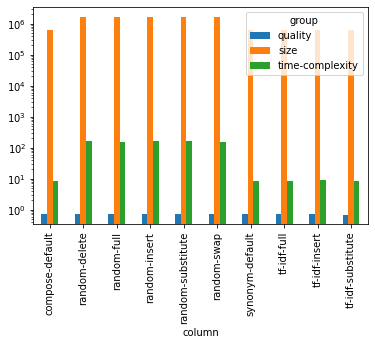

In [36]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

chars_names = ["time-complexity", "quality", "size"]
columns = storage
data_to_plot = []
for i in range(3):
    for column in columns:
        characteristic = characteristics[column][i]
        data_to_plot.append([chars_names[i], column, characteristic])

df = pd.DataFrame(data=data_to_plot, columns=['group', 'column', 'val'])
df.pivot("column", "group", "val").plot(kind='bar')
plt.yscale("log")
plt.show()

In [0]:
time_complexity = dict()
model_quality = dict()
model_size = dict()

dictes = [time_complexity, model_quality, model_size]

for i in range(3):
    for column in columns:
        characteristic = characteristics[column][i]
        dictes[i][column] = characteristic


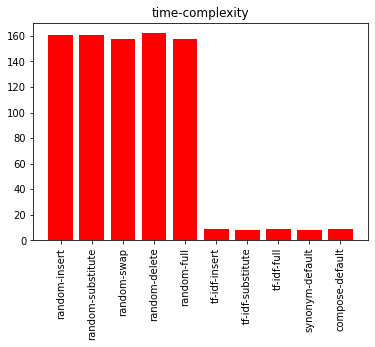

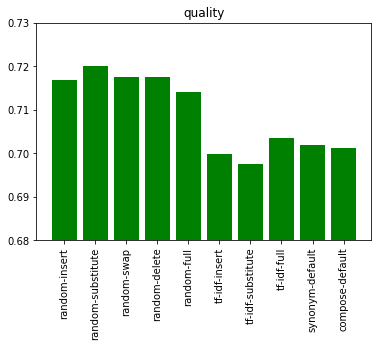

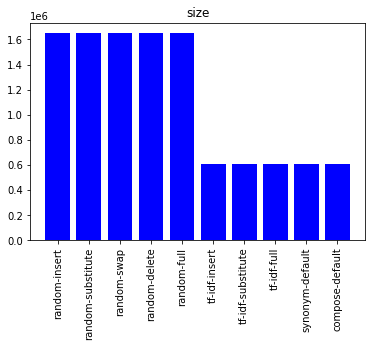

In [47]:
colors = ['r', 'g', 'b']

for i in range(3):
    if i == 1:
        plt.ylim((0.68, 0.73))
    plt.title(chars_names[i])
    plt.bar(dictes[i].keys(), dictes[i].values(), color=colors[i])
    plt.xticks(rotation='vertical')
    plt.show()

**Conclusion:** character-level embeddings do not differ because of chosen action type. Even if it is full combination of insert, delete and substitute, the resulting accuracy will stay the same as we would only use insert.